# PROJECT : Spam SMS Data Analytics

`WORK IN PROGRESS`

In [2]:
import pandas as pd 
import numpy as np
import csv

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.multiclass import OneVsRestClassifier


from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("./SMSSpamCollection.csv", sep='\t', quoting=csv.QUOTE_NONE, names=["label", "message"])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.label.value_counts()

ham     4827
spam     747
Name: label, dtype: int64

## Loading NLTK (Natural Language Toolkit)

In [ ]:
import nltk 
nltk.download('all')

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

## Tokenization 

In [8]:
def splitIntoTokens(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

In [ ]:
df['tokenized_message'] = df['message'].apply(splitIntoTokens)

## Lemmatization (convert a word into its base form)

In [9]:

def getLemmas(tokens):
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        lemmas.append(lemmatizer.lemmatize(token))
    return lemmas

In [ ]:

df['lemmatized_message'] = df['tokenized_message'].apply(getLemmas)

## Removing Stop Words 

In [10]:
stopWords = set(stopwords.words('english'))
def removeStopWords(lemmas):
    filteredSentence = []
    filteredSentence = ' '.join([word for word in lemmas if word not in stopWords])
    return filteredSentence 

In [ ]:

df['filtered_message'] = df['lemmatized_message'].apply(removeStopWords)

## TFIDF Matrix
- The Term Document Matrix (TDM) is a matrix that contains the frequency of occurrence of terms in a collection of documents.
- In a Term Frequency Inverse Document Frequency (TFIDF) matrix, the term importance is expressed by Inverse Document Frequency (IDF)
- IDF diminishes the weight of the most commonly occurring words and increases the weightage of rare words.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df = 1/df.shape[0], 
    max_df = 0.7
)

In [12]:


tfidfModel = tfidfVectorizer.fit(df['filtered_message'])

In [13]:
X = tfidfModel.transform(df['filtered_message']).toarray()
y = df['label'].values

print(X.shape, y.shape)


(5574, 40373) (5574,)


## Stratified Shuffle Sampling

In [87]:
data_gen = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=7)

## Models Pool

In [94]:
classifiers = [
    DecisionTreeClassifier(),
    GaussianNB(),
    SGDClassifier(loss='modified_huber', shuffle=True),
    SVC(kernel="linear", C=0.025),
    KNeighborsClassifier(),
    OneVsRestClassifier(LinearSVC()),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=10),
    AdaBoostClassifier(),
]

models_params = []
for model in classifiers:
    for train_index, test_index in data_gen.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        model_report = report['spam']
        model_report.update({
            'model' : type(model).__name__,
            'accuracy' : report['accuracy']
        })

        models_params.append(model_report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [96]:
report_df = pd.DataFrame(models_params)

report_df

,precision,recall,f1-score,support,model,accuracy
0,0.880734,0.857143,0.868778,224,DecisionTreeClassifier,0.965332
1,0.658863,0.879464,0.753346,224,GaussianNB,0.922893
2,1.000000,0.816964,0.899263,224,SGDClassifier,0.975493
3,0.000000,0.000000,0.000000,224,SVC,0.866109
4,1.000000,0.160714,0.276923,224,KNeighborsClassifier,0.887627
5,0.989130,0.812500,0.892157,224,OneVsRestClassifier,0.973700
6,0.000000,0.000000,0.000000,224,RandomForestClassifier,0.866109
7,0.943590,0.821429,0.878282,224,AdaBoostClassifier,0.969516


In [100]:
del report_df['support']

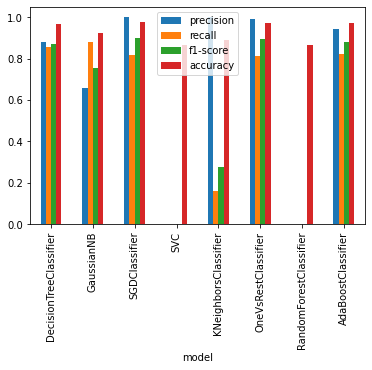

In [101]:
report_df.plot.bar(x='model')